In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils, models
import PIL.Image as Image
import torchvision
import torch.nn as nn
import torch.optim as optim
import sys

In [2]:
sys.path.insert(0, '../src')
from bird_dataset import *

In [3]:
bd = BirdDataset()

In [4]:
class XAI_Birds_Dataset(Dataset):
    
    def __init__(self, bd:BirdDataset, subset=True, transform=None, train=True):
        self.bd = bd
        self.transform = transform
        self.subset = subset
        self.train = train
        if self.train: self.train_test_indices = self.bd.train_indices
        else: self.train_test_indices = self.bd.test_indices
        
        if self.subset: self.class_dict = self._set_classes('classes-subset')
        else: self.class_dict = self._set_classes('classes')
        self.images = self.load_images()
        
        
    def __len__(self):
        return len(self.images)
        
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        img_id = list(self.images.keys())[idx]
        img_path = os.path.join(self.bd.img_dir, self.images[img_id]['filepath'])
        image = Image.open(img_path)
        label = self.class_dict[self.images[img_id]['class_label']]
        sample = {'image': image, 'label':label}
        
        if self.transform:
            sample['image'] = self.transform(sample['image'])
        return sample
    def _set_classes(self, fname):
        with open(f'../CUB_200_2011/{fname}.txt') as f:
            class_dict = {int(line.split(' ')[0]):i for i, line in enumerate(f.readlines())}
        return class_dict
    
    def load_images(self):
        images = {}
        for key in self.bd.images:
            class_label = self.bd.images[key]['class_label']
            if class_label in list(self.class_dict.keys()) and class_label in self.train_test_indices:
                images[key] = self.bd.images[key] 
        return images

In [6]:
trans = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])
train_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=True)
val_bird_dataset = XAI_Birds_Dataset(bd, transform=trans, train=False)

In [7]:
model = models.vgg16_bn(pretrained=False)
num_feats = model.classifier[6].in_features
features = list(model.classifier.children())[:-1]
features.extend([nn.Linear(num_feats, len(train_bird_dataset.class_dict))])
model.classifier = nn.Sequential(*features) # Replace the model classifier

In [8]:
model.load_state_dict(torch.load('../models/vgg16_31_class_50_epoch_4_batch.pth'))

<All keys matched successfully>

In [9]:
model.eval();

In [10]:
# batch_size = 4
trainloader = DataLoader(train_bird_dataset)
valloader = DataLoader(val_bird_dataset)

In [11]:


# The function to show an image.
def imshow(img):
#     img = img / 2 + 0.5     # Unnormalize.
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()



In [12]:
# dataiter.next()

In [13]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


In [14]:
if torch.cuda.is_available():
    model.cuda()

In [15]:
class_dict = val_bird_dataset.class_dict

In [16]:
inv_classes = {v: k for k, v in class_dict.items()}

In [17]:
# labels

In [18]:
def topk_accuracy(k, labels, outputs):
    num_correct = 0
    _, predicted = outputs.topk(5, -1, largest=True, sorted=True)
    for idx, pred in enumerate(predicted):
#         print(labels[idx])
#         print(pred)
        if int(labels[idx]) in np.array(pred.cpu()): 
            num_correct += 1
    return num_correct

In [19]:
%%time
num_correct = 0
num_correct_k = 0
k = 5
# Check several images.
dataiter = iter(valloader)
batch_size = 1
for i in range(len(dataiter)):
    sample = dataiter.next()
    images, labels = sample['image'], sample['label']    
    outputs = model(images.to(device))
    _, predicted = torch.max(outputs, 1)
    #     print(predicted)
    # print(labels)
    # print(predicted)
    num_correct_k += topk_accuracy(k, labels, outputs)
    num_correct += sum(np.array(labels)==np.array(predicted.cpu()))
    if i % 200 == 0:
        print("iteration",i)

iteration 0
iteration 200
CPU times: user 19.8 s, sys: 54.7 ms, total: 19.8 s
Wall time: 2.82 s


In [20]:
len(trainloader)

1596

In [21]:
print("Accuracy:", num_correct / (len(valloader) * batch_size))
print(f"Top {k} Accuracy:", num_correct_k / (len(valloader) * batch_size))

Accuracy: 0.0
Top 5 Accuracy: 0.35443037974683544


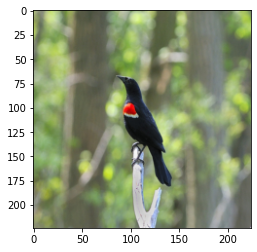

Ground Truth: [10]
Predicted: [191]
Accuracy: 0.0


In [37]:
# Check several images.
dataiter = iter(valloader)
batch_size = 1
# for i in range(len(dataiter)):
sample = dataiter.next()
images, labels = sample['image'], sample['label']
imshow(torchvision.utils.make_grid(images))
# print(labels)
# print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))
outputs = model(images.to(device))
_, predicted = torch.max(outputs, 1)

print("Ground Truth:", [inv_classes[int(labels[i])] for i in range(batch_size)])
print("Predicted:",[inv_classes[int(predicted[i])] for i in range(batch_size)])
print("Accuracy:",sum(np.array(labels)==np.array(predicted.cpu()))/len(labels))

In [38]:
from captum.attr import GuidedGradCam

In [43]:
last_conv = model.features[40]
gc = GuidedGradCam(model, last_conv)
img, label =  val_bird_dataset[0]['image'], val_bird_dataset[0]['label']
for feat in model.features[:41]:
    img = feat(img)

RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 224, 224] instead

In [41]:
gc.attribute(img, label)

/home/jdlevy/anaconda3/envs/py38/lib/python3.8/site-packages/captum/_utils/gradient.py:53: UserWarning: Input Tensor 0 did not already require gradients, required_grads has been set automatically.
  warnings.warn(


RuntimeError: Expected 4-dimensional input for 4-dimensional weight [64, 3, 3, 3], but got 3-dimensional input of size [3, 224, 224] instead